# Baybayin Character Recognition Project

## 1. Setting up environment

In [1]:
# Connect to Google Drive
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Get kaggle.json
import os
from importlib.metadata import distribution, PackageNotFoundError


# Check if we need to download kaggle
try:
  dist = distribution("kaggle")
  print(f"[INFO] {dist.name} ({dist.version}) already exists, skipping download...")
except PackageNotFoundError:
  print(f"kaggle package not found. installing...")
  !pip install kaggle # install kaggle if needed
  dist = distribution("kaggle")
  print(f"[INFO] Successfully installed {dist.name} ({dist.version})!")

# Set up kaggle credentials
if not os.path.isdir(Path.home() / ".kaggle"):
  ! mkdir ~/.kaggle
else:
  print(f"[INFO] {Path.home()}/.kaggle directory already exists.")

print(f"[INFO] Setting up kaggle credentials...")
! cp /content/drive/MyDrive/Grad\ School/project-baybayin/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
print(f"[INFO] Kaggle authentication configured!")

[INFO] kaggle (1.7.4.5) already exists, skipping download...
[INFO] Setting up kaggle credentials...
[INFO] Kaggle authentication configured!


In [3]:
# Create data folder
from pathlib import Path

BASE_DIR = Path("/content")
data_dir = BASE_DIR / "data"

if data_dir.is_dir():
  print(f"[INFO] {data_dir} already exists, will use existing directory...")
else:
  print(f"[INFO] Creating {data_dir} ...")
  data_dir.mkdir(parents=True, exist_ok=True)
  print(f"[INFO] Done!")

[INFO] Creating /content/data ...
[INFO] Done!


## 2. Downloading data

In [4]:
# Download data
!kaggle datasets download danielhammond/baybayin-character-dataset -p /content/data

Dataset URL: https://www.kaggle.com/datasets/danielhammond/baybayin-character-dataset
License(s): apache-2.0
 83% 329M/397M [00:00<00:00, 749MB/s]
100% 397M/397M [00:00<00:00, 594MB/s]


In [5]:
# Unzip data file
import zipfile
zipped_data = "/content/data/baybayin-character-dataset.zip"

with zipfile.ZipFile(zipped_data, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

## 3. Creating a Dataset class

In [6]:
# Import libraries
import os
import torch
import torchvision

import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms
from typing import Dict, List, Tuple

In [7]:
# Create Dataset class

class BaybayinDataset(Dataset):
  # Init func
  def __init__(self, data_path, transform=None):
    self.paths = list(Path(dataset_path).glob('*/*.[jJ][pP][gG]'))
    self.classes, self.class_to_idx = self.find_classes(data_path=data_path)
    self.transform = transform

  # Override __len__
  def __len__(self):
    return len(self.paths)

  # Override __getitem__
  def __getitem__(self, idx):
    image = self.load_image(idx)
    img_class = self.paths[idx].parent.name
    img_class_idx = self.class_to_idx[img_class]

    # Transform if necessary
    if self.transform:
      return self.transform(image), img_class_idx
    else:
      return image, img_class_idx


  # Helper class to find classes
  def find_classes(self, data_path: str) -> Tuple[List[str], Dict[int, str]]:
    """ Find classes given a folder containing subfolders of data. """
    # 1. Get class names
    classes = sorted([entry.name for entry in os.scandir(data_path) if entry.is_dir()])

    # 2. Raise error if no class names
    if not classes:
      raise FileNotFoundError(f"No classes found in {data_path}. Please check file structure.")

    # 3. Get a dictionary of class names
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

  # Helper function to load image
  def load_image(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

### 3.1 Creating BaybayinDataset instance

In [8]:
dataset_path = data_dir / 'Baybayin Character Dataset' / 'Grouped'
dataset_path

PosixPath('/content/data/Baybayin Character Dataset/Grouped')

In [9]:
# Set up data transform
from torchvision.models import ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
preprocess = weights.transforms()
preprocess
# transform = transforms.Compose([
#     transforms.Resize(size=(32, 32)), # The input is 32x32 image
#     transforms.Grayscale(),
#     transforms.ToTensor()
# ])

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# Create dataset without transforms
dataset = BaybayinDataset(data_path=dataset_path, transform=preprocess)

### 3.2 Visualize dataset images

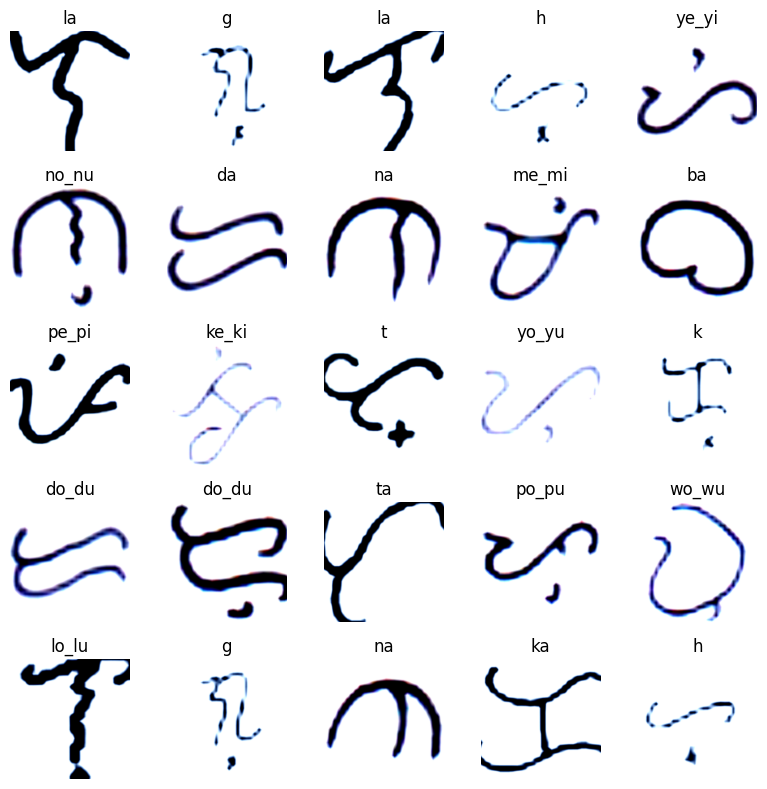

In [11]:
import random

def plot_random_images(data_set=dataset, n=25, nrows=5, ncols=5):
  # Set up figure
  plt.figure(figsize=(8,8))

  # Get class names
  class_names = dataset.classes

  # Start loop
  for i in range(1, n+1):

    # Get random image
    rand_idx = random.randint(0, len(dataset))
    rand_img, rand_img_class = dataset.__getitem__(rand_idx)

    # Plot image
    plt.subplot(nrows, ncols, i)
    plt.imshow(rand_img.permute(1, 2, 0))
    plt.title(class_names[rand_img_class])
    plt.axis(False)

  plt.tight_layout()
  plt.show()

plot_random_images()

### 3.3 Create training and testing data

In [12]:
# Define function to set seeds
def set_seeds(seed:int=17):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define variables
SAMPLES_PER_CLASS = 1000

# Get classes
classes = dataset.classes
# Create indices for each data
indices = np.arange(len(dataset))

# Create matching class list
class_list = []
for i in range(len(classes)):
  class_list.extend([i]*SAMPLES_PER_CLASS)

# Create split
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=class_list
)

len(train_indices), len(test_indices)

(47200, 11800)

Check if startification worked

In [14]:
import pandas as pd
test_index_classes = [class_list[i] for i in test_indices]
df = pd.DataFrame({
    'index': test_indices,
    'class': test_index_classes
})
df.value_counts('class')

,count
class,
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


In [15]:
train_index_classes = [class_list[i] for i in train_indices]
df = pd.DataFrame({
    'index': train_indices,
    'class': train_index_classes
})
df.value_counts('class')

,count
class,
0,800
1,800
2,800
3,800
4,800
5,800
6,800
7,800
8,800


### 3.4. Create dataloaders

In [16]:
# Create data subsets
from torch.utils.data import DataLoader, Subset

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

In [17]:
# Create dataloaders
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

print(f'There are {len(train_loader)} batches of size {BATCH_SIZE} for training.')
print(f'There are {len(test_loader)} batches of size {BATCH_SIZE} for testing.')


There are 369 batches of size 128 for training.
There are 93 batches of size 128 for testing.


In [18]:
# Get torch shape [B, C, H, W]
next(iter(train_loader))[0].shape

torch.Size([128, 3, 224, 224])

## 4. The ViT Model

### 4.1 Create ViT model


In [19]:
# Based on the LeNet 5 architecture
from torchvision.models import vit_b_16
# Create model instance
set_seeds()
model = vit_b_16(weights=weights)
model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 191MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [20]:
# Check model summary
try:
  from torchinfo import summary
except:
  print(f'[INFO] Could not find torchinfo, downloading...')
  ! pip install -q torchinfo
  from torchinfo import summary
  print(f'[INFO] Successfully downloaded torchinfo!')

summary(model,
        input_size=[32, 3, 224, 224],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

[INFO] Could not find torchinfo, downloading...
[INFO] Successfully downloaded torchinfo!


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [21]:
# Freeze base layers
for params in model.parameters():
  params.requires_grad = False

In [22]:
# Update classifier head to match len(class_names)
set_seeds()
model.heads = nn.Linear(in_features=768, out_features=len(dataset.classes))

In [23]:
# Get new model summary
summary(model,
        input_size=[32, 3, 224, 224],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 59]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## 5. Train/test

### 5.1. Create `train` and `test` steps

In [24]:
# Training step
def train_step(model: torch.nn,
               train_loader: torch.utils.data.DataLoader,
               criterion: torch.nn,
               opt: torch.optim,
               device: torch.device,
               epochs:int):
  """ Trains a given model for one epoch. """
  # Define loss and acc
  train_loss, train_acc = 0, 0

  # Set model to train mode
  model.train()


  # Loop through dataloader
  for batch, (X, y) in enumerate(train_loader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # Make pred
    y_logits = model(X)
    y_preds = torch.argmax(y_logits, dim=1)
    loss = criterion(y_logits, y)
    train_loss += loss.item()

    # Gradient descent
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Get accuracy
    acc = (y_preds == y).sum().item() / len(y)
    train_acc += acc

  # Get average loss and acc
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [25]:
# Testing step
def test_step(model: torch.nn,
              test_loader: torch.utils.data.DataLoader,
              criterion: torch.nn,
              device: torch.device):
  """ Evaluates a model performance given testing data. """
  # Initialize loss and acc
  test_loss, test_acc = 0, 0

  # Turn model to predict mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      y_preds = torch.argmax(y_logits, dim=1)
      loss = criterion(y_logits, y)
      test_loss += loss.item()

      acc = (y_preds == y).sum().item() / len(y)
      test_acc += acc

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

  return test_loss, test_acc

### 5.2. Define a training loop function

In [26]:
# Training loop
from tqdm.auto import tqdm
from torch.optim import lr_scheduler

def train(model: torch.nn,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          criterion: torch.nn,
          opt: torch.optim,
          device: torch.device,
          epochs:int=5):
  """ Performs a train/test loop on a model for certain number of epochs. """
  # Send model to device
  model.to(device)

  # Create a results dictionary
  results = {
      'train_loss': [],
      'train_acc': [],
      'test_loss': [],
      'test_acc': []
  }

  # Create learning rate scheduler
  # scheduler = lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

  # Perform train-test loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, opt, device, epochs)
    test_loss, test_acc = test_step(model, test_loader, criterion, device)

    # Update learning rate
    # scheduler.step()

    # Print results
    print(f"Epoch {epoch+1}| "
          f"Train loss: {train_loss:.4f} | "
          f"Train acc: {train_acc:.4f} | "
          f"Test loss: {test_loss:.4f} | "
          f"Test acc: {test_acc:.4f}"
    )

    # Store results
    results['train_loss'].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results['train_acc'].append(train_acc.item() if isinstance(train_acc,torch.Tensor) else train_acc)
    results['test_loss'].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results['test_acc'].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 5.3 Train model with baseline hyperparameters

In [27]:
# Set up device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [29]:
from timeit import default_timer as timer
start_time = timer()
results = train(model, train_loader, test_loader, criterion, opt, device, epochs=5)
end_time = timer()

print(f"Total training timer: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1| Train loss: 0.9514 | Train acc: 0.8089 | Test loss: 0.4088 | Test acc: 0.9164
Epoch 2| Train loss: 0.3030 | Train acc: 0.9407 | Test loss: 0.2517 | Test acc: 0.9452
Epoch 3| Train loss: 0.2037 | Train acc: 0.9596 | Test loss: 0.1875 | Test acc: 0.9607
Epoch 4| Train loss: 0.1573 | Train acc: 0.9690 | Test loss: 0.1574 | Test acc: 0.9652
Epoch 5| Train loss: 0.1292 | Train acc: 0.9743 | Test loss: 0.1343 | Test acc: 0.9707
Total training timer: 3537.558 seconds


## 6. Visualize results

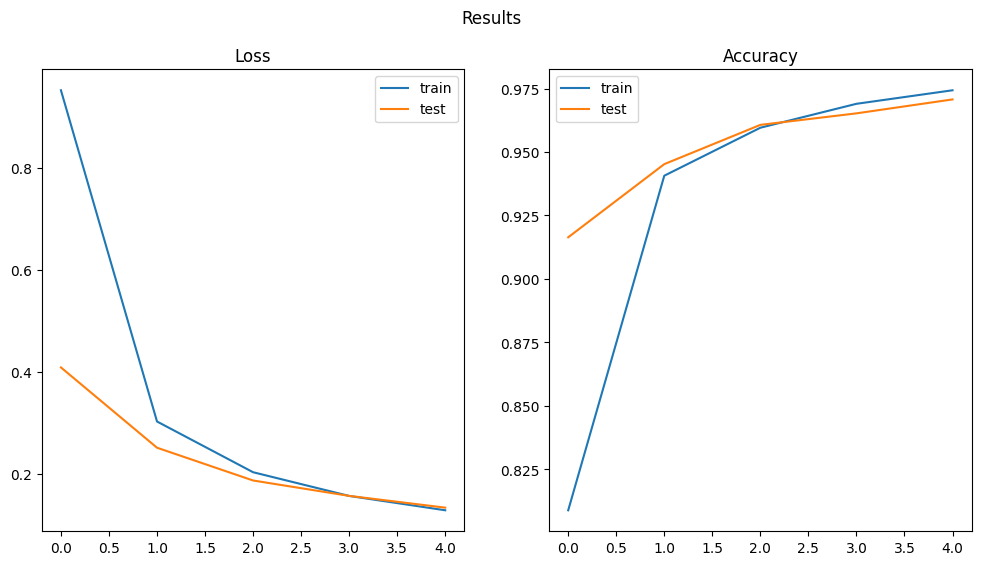

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='train')
plt.plot(results['test_acc'], label='test')
plt.title('Accuracy')
plt.legend()

plt.suptitle('Results')
plt.show()

In [31]:
# Write a function that will return the predictions, truth labels, and data.

def predict(model: torch.nn.Module,
            test_loader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[List[torch.Tensor], List[int], List[int]]:
  """ Make predictions from a test set using a model.

  Args:
    model
      A PyTorch model used for prediction
    test_set
      A PyTorch DataLoader containing the test dataset.
    device
      A PyTorch device where the model and data resides.

  Returns:
    A Tuple of the test data, ground truth labels, prediction labels and score.
    In the form of:
      data, truth_labels, pred_labels, score
  """
  # Initialize lists
  data = []
  truth_labels = []
  pred_labels = []
  score = []

  # Send model to device
  model.to(device)

  # Turn model to eval mode
  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)

      scores = model(X).softmax(dim=1)
      predictions = scores.argmax(dim=1)
      # print(scores)
      scores = torch.gather(scores, 1, predictions.unsqueeze(1)).squeeze(1)
      # print(predictions.unsqueeze(0).shape)

      # Append to list
      data.append(X)
      truth_labels.append(y)
      pred_labels.append(predictions)
      score.append(scores)

    # Concatenate results and convert to cpu for numpy processing
    data = torch.cat(data, dim=0).cpu()
    truth_labels = torch.cat(truth_labels, dim=0).cpu().numpy()
    pred_labels = torch.cat(pred_labels, dim=0).cpu().numpy()
    score = torch.cat(score, dim=0).cpu().numpy()

  return data, truth_labels, pred_labels, score

In [32]:
# Make predictions
data, truth_labels, pred_labels, score = predict(model, test_loader, device)
len(data), len(truth_labels), len(pred_labels), len(score)

(11800, 11800, 11800, 11800)

Text(0.5, 1.0, 'Confusion Matrix')

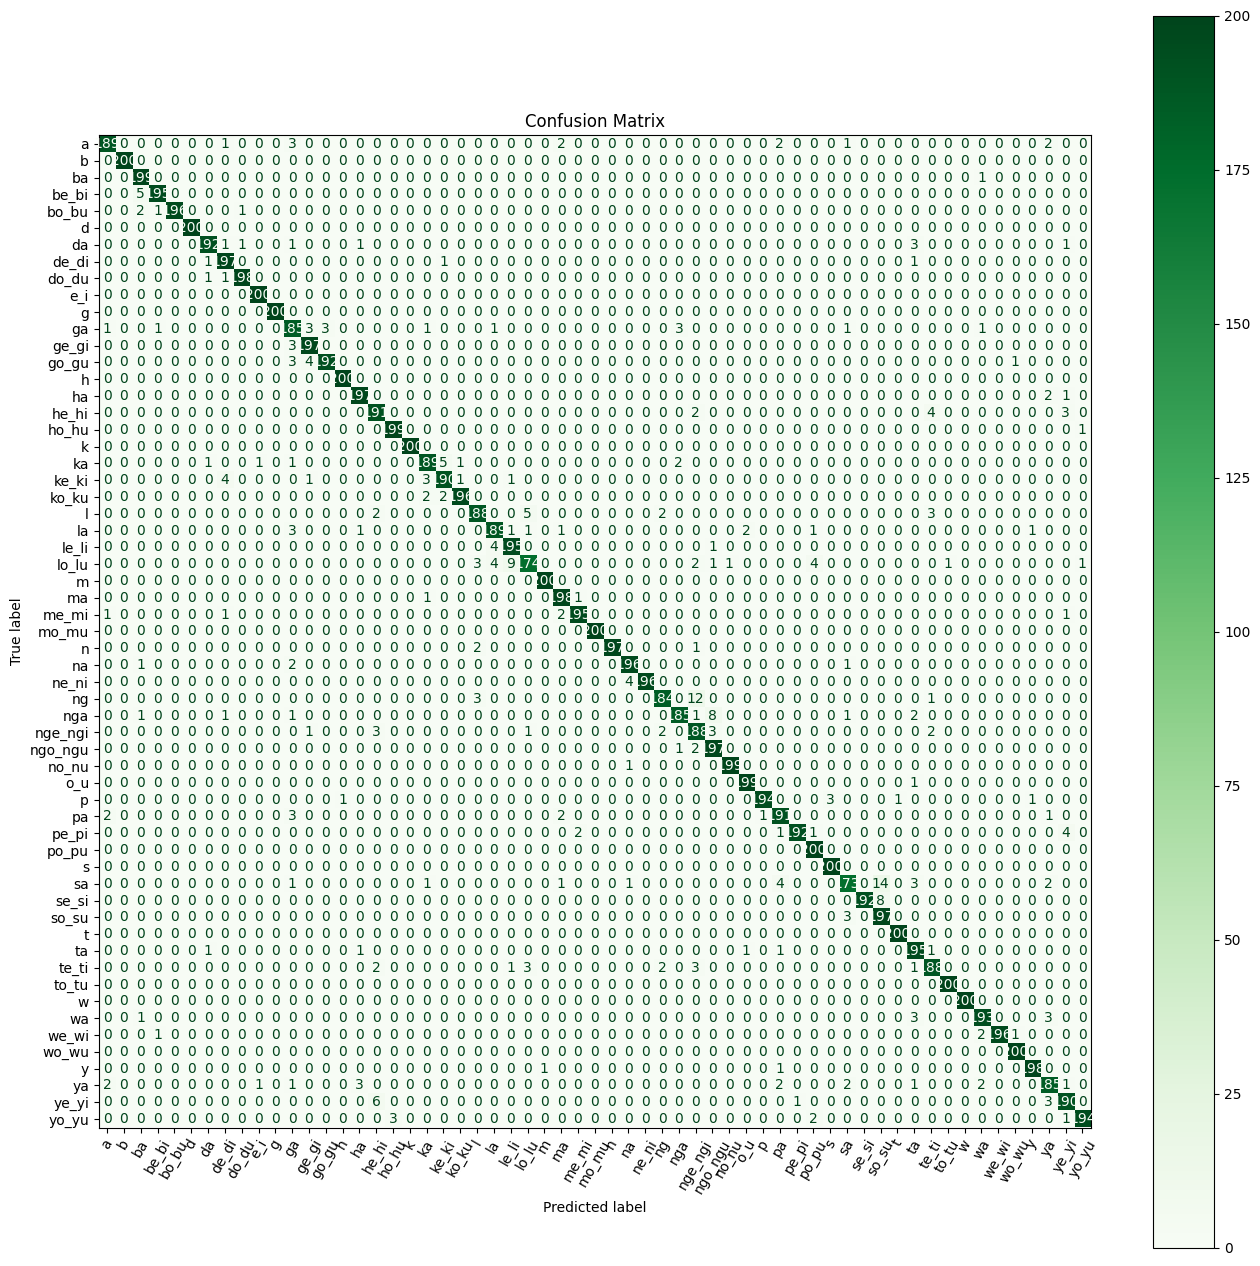

In [33]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truth_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)

# plt.figure(figsize=(16,16))
disp.plot(cmap='Greens',xticks_rotation=60)
disp.ax_.figure.set_size_inches(16, 16)
disp.ax_.set_title('Confusion Matrix')

## 7. Save working model

In [35]:
from pathlib import Path
import os

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)


In [37]:
save_model(model=model,
           target_dir="models",
           model_name="vit_baybayin_model.pth")

[INFO] Saving model to: models/vit_baybayin_model.pth
